In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

import pickle

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
from keras.callbacks import TensorBoard

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [3]:
style.use('ggplot')

In [4]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

In [3]:
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

NameError: name 'df' is not defined

In [6]:
df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

In [7]:
df['moving_distance'] = np.abs(df.latitude.diff() * 111000) + np.abs(df.longitude.diff() * 110987)

In [8]:
df = df[(df['hr_value'] != 0)]

In [9]:
# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on sunday

In [10]:
dfsteptotal = pd.DataFrame()
dfsteptotal = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfsteptotal = dfsteptotal[~dfsteptotal.index.duplicated(keep='first')]
dfsteptotal['steps'] = 0
dfsteptotal.reset_index(inplace=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['5'], 'steps':[0]})
dfsteptotal = dfsteptotal.append(dfadd, ignore_index=True)
dfsteptotal = dfsteptotal.set_index(['week', 'weekday'])
dfsteptotal.sort_index(inplace=True)

In [11]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'morning', 1:'afternoon', 2:'evening'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=0,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=23,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])

        dfsteptotal.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           ['steps']] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
        print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(days=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [12]:
dfsteptotal.loc[(12,'5')] = dfsteptotal.xs('5', level=1).sum() / (dfsteptotal.xs('5', level=1).count() - 1)

In [13]:
dfsteptotal['Comfort'] = 0
dfsteptotal['Precp'] = 0

In [14]:
dfsteptotal

steps  Comfort  Precp
week weekday                         
12   3         2366.0        0      0
     4         2104.0        0      0
     5         5336.0        0      0
     6         3093.0        0      0
13   0         1141.0        0      0
     1        10432.0        0      0
     2         6940.0        0      0
     3         5919.0        0      0
     4         5479.0        0      0
     5         4191.0        0      0
     6         5143.0        0      0
14   0         8837.0        0      0
     1         5707.0        0      0
     2         4132.0        0      0
     3         5911.0        0      0
     4         2847.0        0      0
     5         5635.0        0      0
     6         6117.0        0      0
15   0         8264.0        0      0
     1        13747.0        0      0
     2         5927.0        0      0
     3         7313.0        0      0
     4         9577.0        0      0
     5         6182.0        0      0
     6         7815.0        0      0
16   0         5815.0        0      0
     1        11515.0        0      0
     2         7376.0        0      0
     3            0.0        0      0

In [15]:
# add wether 
coding = 'utf-8'
table = pd.DataFrame()
basetime = datetime.date(2019,3,27)
num = 0
for index, row in dfsteptotal.iterrows():
    try:
        # parsing part
        date = basetime + datetime.timedelta(days = num)
        print(date)
        num += 1
        dateStr = date.strftime('%Y-%m-%d')
        url = 'https://e-service.cwb.gov.tw/HistoryDataQuery/DayDataController.do?command=viewMain&station=C0AC60'+ \
            '&stname=%25E4%25B8%2589%25E5%25B3%25BD&datepicker=' + dateStr
        table = pd.read_html(url,encoding=coding,index_col=0,header=None,flavor='bs4')[1]
        # start dataprocess
        table.replace('/', np.nan, inplace=True)
        table.replace('X', np.nan, inplace=True)  
        table.fillna(method='ffill', inplace=True)
        table.index -= 1
        dfoneday = pd.DataFrame()
        # the table data need to reshape and turn to a variable
        T = table['temperature'].values.reshape(len(table['temperature'].values)).astype('float')
        RH = table['RH'].values.reshape(len(table['RH'].values)).astype('float')
        dfoneday['comfort'] = T - 0.55 *(1-RH/100)*(T - 14)
        dfoneday['Precp'] = table['Precp']['降水量(mm)']
        bins = [0,11,16,20,27,31,60]
        labels=[0,1,2,3,4,5]
        dfoneday['bins'] = pd.cut(dfoneday['comfort'], bins=bins, labels=labels, include_lowest=True)
        # mComfort aComfort eComfort mPrecp aPrecp ePrecp
        dfsteptotal.loc[[index], ['Comfort']] = dfoneday['bins'].astype(int).mean()
        dfoneday['Precp'].astype(float)
        dfsteptotal.loc[[index], ['Precp']] = dfoneday['Precp'].astype(float).sum()
    except Exception as e:
        if str(e) == "could not convert string to float: '...'":
            print('some data are not yet ready')
            break

2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-06
2019-04-07
2019-04-08
2019-04-09
2019-04-10
2019-04-11
2019-04-12
2019-04-13
2019-04-14
2019-04-15
2019-04-16
2019-04-17
2019-04-18
2019-04-19
2019-04-20
2019-04-21
2019-04-22
2019-04-23
2019-04-24
some data are not yet ready


In [16]:
dfsteptotal

steps       Comfort  Precp
week weekday                              
12   3         2366.0  2.666667e+00    0.0
     4         2104.0  2.875000e+00    0.0
     5         5336.0  2.916667e+00   13.0
     6         3093.0  2.583333e+00    3.5
13   0         1141.0  2.000000e+00    0.5
     1        10432.0  1.708333e+00    5.0
     2         6940.0  2.291667e+00    0.0
     3         5919.0  2.416667e+00    0.0
     4         5479.0  2.875000e+00    0.0
     5         4191.0 -3.843072e+17    0.0
     6         5143.0  2.708333e+00    0.0
14   0         8837.0  2.833333e+00    0.0
     1         5707.0  3.000000e+00    0.0
     2         4132.0  3.041667e+00    0.0
     3         5911.0  3.000000e+00    0.0
     4         2847.0  2.625000e+00   21.0
     5         5635.0  2.083333e+00    0.0
     6         6117.0  2.708333e+00    2.5
15   0         8264.0  2.833333e+00    1.5
     1        13747.0  2.083333e+00    2.0
     2         5927.0  2.000000e+00   40.5
     3         7313.0  2.541667e+00    0.0
     4         9577.0  2.750000e+00    0.0
     5         6182.0  3.000000e+00   16.0
     6         7815.0 -3.843072e+17    5.0
16   0         5815.0  3.000000e+00   39.5
     1        11515.0  3.250000e+00    1.0
     2         7376.0  3.291667e+00    0.0
     3            0.0  0.000000e+00    0.0

In [17]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences[0])):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences[0])-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[0][i:end_ix].reshape(len(sequences[0][i:end_ix]),1) 
        seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
        seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y1 =  sequences[0][end_ix]
        X.append(seq_x)
        y.append(seq_y1)
    return np.array(X), np.array(y)

In [18]:
steps = dfsteptotal['steps'][:-1].values
Comfort = dfsteptotal['Comfort'][:-1].values
Precp = dfsteptotal['Precp'][:-1].values

# dataset = np.array([steps, Comfort, Precp])
normalized_X = preprocessing.normalize([steps])
normalized_Y = preprocessing.normalize([Comfort])
normalized_Z = preprocessing.normalize([Precp])
dataset = np.array([normalized_X[0],normalized_Y[0],normalized_Z[0]])
n_steps = 3
X, y = split_sequences(dataset, n_steps)
for i in range(1):
    print(X[i], y[i])

[[6.52932415e-02 4.90653893e-18 0.00000000e+00]
 [5.80629671e-02 5.28986229e-18 0.00000000e+00]
 [1.47254749e-01 5.36652696e-18 2.01981733e-01]] 0.08535587317238158


In [19]:
tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [20]:
n_features = 3
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50 ,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             448       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 3,749
Trainable params: 3,749
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X, y, epochs=150, verbose=0, batch_size=128, validation_split=0.2,  callbacks=[tbCallBack])

<IPython.core.display.Javascript object>


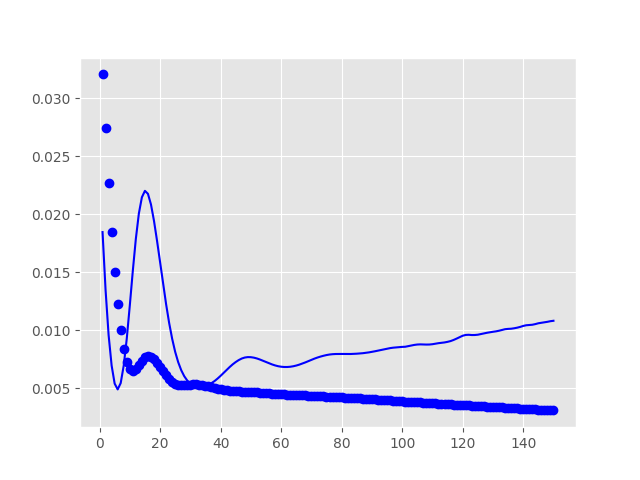

In [22]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [23]:
n_features = 3
model = Sequential()
model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(50 ,activation='relu'))
model.add(keras.layers.LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 100)            41600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X, y, epochs=100, verbose=0, batch_size=128, validation_split=0.2,  callbacks=[tbCallBack])

<IPython.core.display.Javascript object>


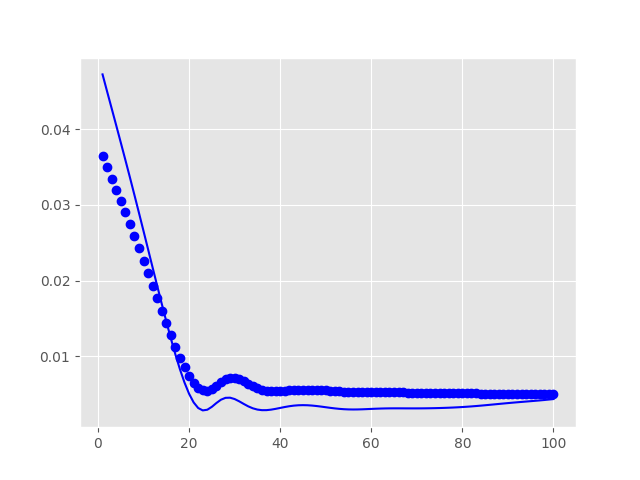

In [26]:
%matplotlib notebook
loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.show()

In [5]:
# split a multivariate sequence into samples
def split_sequences_hour(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
       # find the end of this pattern
        end_ix = i + n_steps
#         print(end_ix)
        #check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]#.reshape(len(sequences[i:end_ix]),1) 
#         print(seq_x)
#         break
#         seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
#         seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
        seq_y = sequences[end_ix][-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
def start_hourly_predict(training_steps = 3):
    conn = MongoClient('120.126.136.17')
    db = conn.Tracker
#     collection = [db.User_Info]# db.db2, db.dn2, db.james, db.leo
#     userInfo = []
#     for col in collection:
#         cursor = col.find({})
#         df_user = pd.DataFrame(list(cursor))

#     for username in df_user['']:
#         if username == 'pitest' or username == 'jack' or username == 'manager':
#             continue
    collection = [db['james']]

# collection = [db.james]# db.db2, db.dn2, db.james, db.leo
    clean_data = []
    for col in collection:
        cursor = col.find({})
        df = pd.DataFrame(list(cursor))
    df.replace('', np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)

    df['hr_value'] = df['hr_value'].astype(float)
    df['o2_value'] = df['o2_value'].astype(float)
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['step_value'] = df['step_value'].astype(float)

    # map out the weekday
    df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
    df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
              - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

    dfstephour = pd.DataFrame({})
    dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
    dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
    earlestweek = df['week'].values[0]
    latestweek = df['week'].values[-1]
    addindex = pd.DataFrame({})
    for i in range(earlestweek, latestweek):
        for j in range(7):
            if not (i,str(j)) in dfstephour.index:
                add = pd.DataFrame({'week':[i],'weekday':[str(j)]})
                addindex = addindex.append(add)
    dfstephour.reset_index(inplace=True)
    dfstephour = dfstephour.append(addindex)
    dfstephour = dfstephour.set_index(['week', 'weekday'])
    dfstephour = dfstephour.sort_index()
    for i in range(24):
        dfstephour[i] = 0

    # here I map between integer and the sting it's mean
    timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
    basestamp = df['timestamp'][0]
    endstamp = df['timestamp'][-1:].values[0]
    # for num, row in df[:30000].iterrows():
    while True:
        try:
            hour = datetime.datetime.fromtimestamp(basestamp).hour
            dfbetween = df.loc[df['timestamp'].between(
                datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
                datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                        , inclusive=True)]
            steps = dfbetween['step_value'].sum()
        #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
        #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
        #                 timeslidemap[estimedevide])

            dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                        (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                                datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                               [hour]] += steps

            basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
            if basestamp > endstamp:
                break
        except Exception as e:
    #         print(str(e))
            basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
    #     else:
    #         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))
    steps = dfstephour.values
    train_X = []
    for weekday,i in enumerate(steps):
        for hour,j in enumerate(i):
            add = np.array([j])#[weekday, hour, j]
            train_X.append(add)
    # the ending of training data is the  hour of now 
    train_X = train_X[:-(24-datetime.datetime.now().time().hour + 1)]
    train_X = np.array(train_X)

    n_steps = training_steps
    X, y = split_sequences_hour(train_X, n_steps)

    n_features = 1
    model = Sequential()
    model.add(keras.layers.LSTM(100,activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
    model.add(keras.layers.LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X, y, epochs=100, verbose=0, batch_size=128, validation_split=0.2)

    conn.close()

    return history

In [33]:
with open('trainHistoryDict', 'wb') as f:
    for i in range(3,11):
        history = start_hourly_predict(training_steps=i)
        pickle.dump(history.history, f)

In [34]:
lis = []
with open('trainHistoryDict', 'rb') as f:
    while True:
        try: 
            o = pickle.load(f)
        except EOFError:
            break
        lis.append(o)

In [35]:
len(lis)

8

<IPython.core.display.Javascript object>


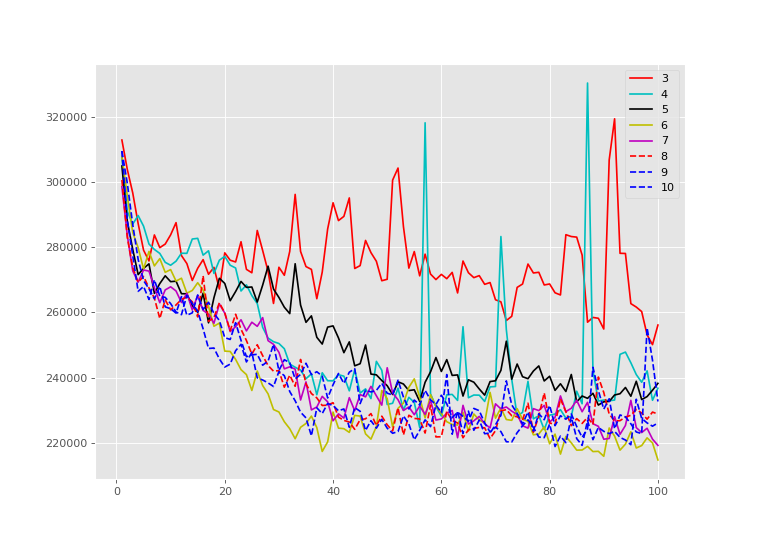

In [37]:
%matplotlib notebook
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']
epochs = range(1, 100 + 1)
plt.plot(epochs, lis[len(lis) -1]['loss'], 'r',label=3)
plt.plot(epochs, lis[len(lis) -2]['loss'], 'c',label=4)
plt.plot(epochs, lis[len(lis) -3]['loss'], 'k',label=5)
plt.plot(epochs, lis[len(lis) -4]['loss'], 'y',label=6)
plt.plot(epochs, lis[len(lis) -5]['loss'], 'm',label=7)
plt.plot(epochs, lis[len(lis) -6]['loss'], 'r--', label=8)
plt.plot(epochs, lis[len(lis) -7]['loss'], 'b--', label=9)
plt.plot(epochs, lis[len(lis) -8]['loss'], 'b--', label=10)
# plt.plot(epochs, lis[len(lis) -9]['loss'], 'b--', label=10)


plt.legend()
# plt.plot(epochs, lis[1]['loss'], 'b')
# plt.plot(epochs, lis[0]['loss'], 'o')


plt.show()